# Project 2

## Imports And Settings

In [1]:
#Imports
import torch
import math
import matplotlib.pyplot as plt

In [2]:
#Deactivating autograd
torch.set_grad_enabled(False)

## Layer Modules

In [3]:
#Fully Connected Layer
class  Linear:
    
    def __init__(self,input_size,output_size,gamma=10**-3):
        
        #Initializing the layer's weights
        self.W=torch.empty(output_size,input_size).normal_()
        
        #Initializing the layer's biases
        self.b=torch.empty(output_size,1).normal_()
        
        #Initializing the learning rate
        self.gamma=gamma
        
        #Initializing the gradients (for param())
        self.gradW=None
        self.gradb=None
    
    def  forward(self , x):
        
        #Memorizing the input for the backpropagation
        self.x_old=x
        
        return torch.mm(self.W,x)+self.b
        
    def backward(self , grads):
        
        #Computing the gradient of the loss with respect to W, b and x
        self.gradW=torch.mm(grads,self.x_old.T)
        self.gradb=torch.sum(grads,axis=1).unsqueeze(1)
        gradx=torch.mm(self.W.T,grads)
        
        #Updating the weights and biases (SGD)
        self.W=self.W-self.gamma*self.gradW
        self.b=self.b-self.gamma*self.gradb
        
        return gradx
        
    def  param(self):
        
        return  [(self.W,self.gradW),(self.b,self.gradb)]

In [4]:
#Concatenation Of Layers
class  Sequential:
    
    def __init__(self,layers):
        
        #Getting the sequence of layers
        self.layers=layers
    
    def  forward(self , x):
        
        #Input of the next layer (x for the first)
        layer_input=x
        
        #Forwarding the input through each layer in sequence
        for layer in self.layers:
            layer_input=layer.forward(layer_input)
        
        #Returning the output of the last layer
        return layer_input
        
    def backward(self , gradwrtoutput):
        
        #Gradient with respect to the output of the last traversed layer (gradwrtoutput at the beginning)
        grad=gradwrtoutput
        
        #Backward propagating the gradient from the last layer to the first
        for layer in reversed(self.layers):
            grad=layer.backward(grad)
            
        #Returning the gradient of the first layer
        return grad
    
    def  param(self):
        
        params=[]
        
        #Getting the param list of each layer
        for layer in self.layers:
            
            for param in layer.param():
                
                params.append(param)
        
        return  params

## Activation Modules

In [5]:
#Rectifier Activation Module
class  ReLU:
    
    def  forward(self , s):
        
        #Saving s for the backward
        self.s=s
        
        #Setting all negative values to 0
        s[s<0]=0
        
        return s
        
    def backward(self , gradx):
        
        #Computing the gradient with respect to s
        grads=gradx*(self.s>0) #∇s max(s,0) = s>0 
        
        return grads
        
    def  param(self):
        return  []

In [6]:
#Hyperbolic Tangent Activation Module
class  Tanh:
        
    
    def  forward(self , s):
        
        #Saving s for the backward
        self.s=s
        
        return 1-2/(1+math.exp(1)**(2*s))
        
    def backward(self , gradx):
        
        #Computing the gradient with respect to s
        grads=gradx*(4/(math.exp(1)**(self.s)+math.exp(1)**(-self.s))) #∇s tanh(s) = 4/(e^s+e^-s)
        
        return grads
        
    def  param(self):
        return  []

In [7]:
#Sigmoid Activation Module
class  sigmoid:
        
    
    def  forward(self , s):
        
        #Saving s for the backward
        self.s=s
        
        return 1/(1+math.exp(1)**(-self.s))
        
    def backward(self , gradx):
        
        #Computing the gradient with respect to s
        #∇s sigmoid(s) = sigmoid(s)*(1-sigmoid(s))
        grads=gradx*((1/(1+math.exp(1)**(-self.s)))*(1-1/(1+math.exp(1)**(-self.s)))) 
        
        return grads
        
    def  param(self):
        return  []

## Loss Modules

In [8]:
#Mean Squared Error Loss Module
class  LossMSE:
    
    def  forward(self , s, y):
        
        #Saving both s and y for the backpropagation
        self.s=s
        self.y=y
        return torch.mean((s-y)**2)
        
    def backward(self):
        
        #Computing the gradient of the loss with respect to s
        self.grads=2*(self.s-self.y)/(self.s.shape[1]*self.s.shape[0]) #∇s MSE(s,y)=2*(s-y)/N
        return self.grads
        
    def  param(self):
        return  []

In [9]:
#Mean Absolute Error Loss Module
class  LossMAE:
    
    def  forward(self , s, y):
        
        #Saving both s and y for the backpropagation
        self.s=s
        self.y=y
        
        #Computing the difference between the actual output and the target output
        delta=s-y
        
        #Inverting the signs when the value is negative to get the absolute values
        delta[delta<0]=-delta[delta<0]
        
        return torch.mean(delta)
        
    def backward(self):
        
        #Computing the difference between the actual output and the target output
        delta=self.s-self.y
        
        #Computing the gradient of the loss with respect to s
        self.grads=((delta<0)*(-1.)+(delta>=0))/(self.s.shape[1]*self.s.shape[0]) #∇s MAE(s,y)=sign(s-y)/N
        return self.grads
        
    def  param(self):
        
        return  []

## Test Architecture

### Main Run

In [10]:
#Helper function generating 'size' inputs and targets
def dataset_generator(size):
    input_=torch.rand((size,2))
    target=(torch.sum((input_-0.5)**2,axis=1)*(2*math.pi)<1)
    return input_,torch.stack([~target,target]).T*1

In [11]:
#Helper function computing the accuracy of our predictions
def accuracy(pred,target):
    return 1.*torch.sum((torch.max(pred,0)[1])==(torch.max(target,0)[1]))/target.shape[1]

In [12]:
#Setting a seed for reproducibility
torch.manual_seed(0) 

#Useful constants
input_size=1000
batch_size=25 #Good tradoff, gives high convergence speed
epochs=4000 #High number, gives enough time for the model to converge
gamma=0.01 # Learning rate shared by all 'Linear' modules
plot_data=torch.empty(4,epochs) #Used to collect data for plotting purposes

#Generating our train and test datasets
train_input, train_targets = dataset_generator(input_size)
test_input, test_targets = dataset_generator(input_size)

#Initializing our model
model=Sequential([Linear(2,25,gamma),Tanh(),Linear(25,25,gamma),Tanh(),Linear(25,25,gamma),Tanh(),Linear(25,2,gamma)])

#Training our model
for epoch in range(epochs):
    
    #Initializing a loss accumulator to compure the average loss of an SGD iteration
    avg_loss=0
    
    #Running an SGD iteration
    for b in range(math.ceil(input_size/batch_size)):
        
        #Computing the lower and upper indices corresponding to the current batch
        low=b*batch_size
        high=min((b+1)*batch_size,input_size)
        
        #Getting the input and target batches
        input_batch=train_input[low:high].T
        target_batch=train_targets[low:high].T
        
        #Forward step
        pred=model.forward(input_batch)
        
        #Computing the loss
        loss_func=LossMSE()
        loss=loss_func.forward(pred,target_batch)
        
        #Backward step
        grad=loss_func.backward()
        model.backward(grad)
        
        #Updating the loss accumulator
        avg_loss=avg_loss+loss.item()
    
    #Dividing the accumulated batch losses to get the average loss of the SGD step
    avg_loss=avg_loss/(input_size//batch_size+1)
    
    #Computing and recording the actual train and test loss and accuracy for plotting 
    pred=model.forward(train_input.T)
    plot_data[0,epoch]=LossMSE().forward(pred,train_targets.T)
    plot_data[1,epoch]=accuracy(pred,train_targets.T)
    
    pred=model.forward(test_input.T)
    plot_data[2,epoch]=LossMSE().forward(pred,test_targets.T)
    plot_data[3,epoch]=accuracy(pred,test_targets.T)
    
    #Printing the results of the current iteration
    print("The average training loss at iteration {} is {}".format(epoch+1,avg_loss),end='\r')

#Desabling the line rewriting    
print('')

#Computing the final training loss
pred=model.forward(train_input.T)
final_loss=LossMSE().forward(pred,train_targets.T)
print("The final training loss is ", final_loss)

#Computing the final test loss
pred=model.forward(test_input.T)
final_loss=LossMSE().forward(pred,test_targets.T)
print("The test loss is ", final_loss)

The average training loss at iteration 4000 is 0.010211390717857994
The final training loss is  tensor(0.0108)
The test loss is  tensor(0.0078)


In [13]:
#Printing the test accuracy to check the actual classification capabilities of the model 
print("The test accuracy is ", accuracy(pred,test_targets.T))

The test accuracy is  tensor(0.9920)


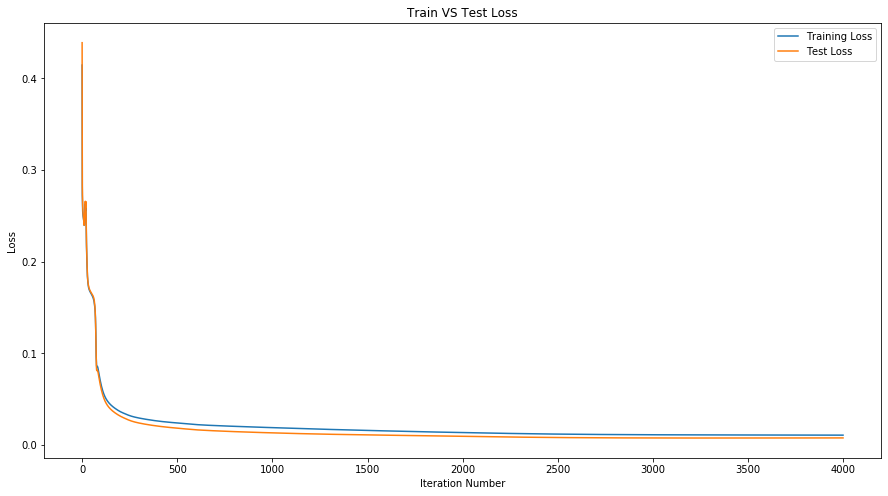

In [14]:
#Plotting the evolution of the train and test accuracy

#Setting-up the plot
plt.figure(figsize=(15,8))

#Drawing and labeling the curves
plt.plot(plot_data[0], label="Training Loss")
plt.plot(plot_data[2], label="Test Loss")

#Adding the title and axis labels
plt.title('Train VS Test Loss')
plt.ylabel('Loss')
plt.xlabel('Iteration Number')
plt.legend()

#Saving the plot
plt.savefig('loss.png')

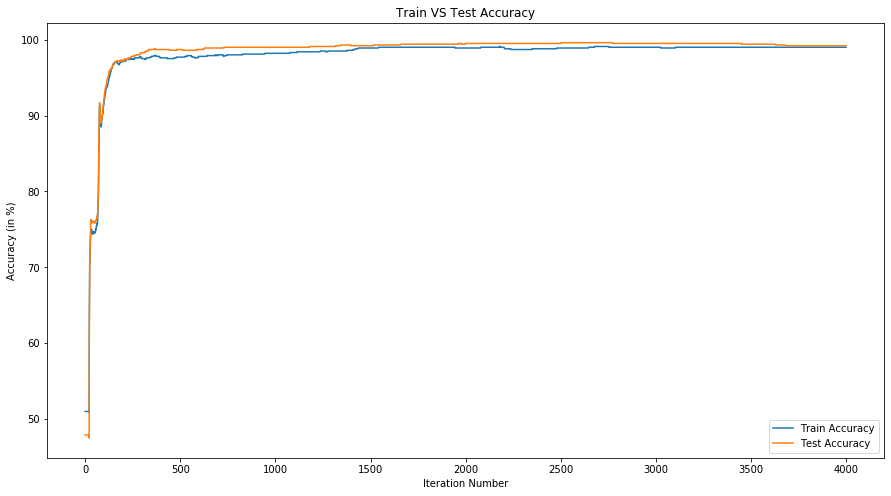

In [15]:
#Plotting the evolution of the train and test accuracy

#Setting-up the plot
plt.figure(figsize=(15,8))

#Drawing and labeling the curves
plt.plot(100*plot_data[1], label="Train Accuracy")
plt.plot(100*plot_data[3], label="Test Accuracy")

#Adding the title and axis labels
plt.title('Train VS Test Accuracy')
plt.ylabel('Accuracy (in %)')
plt.xlabel('Iteration Number')
plt.legend()

#Saving the plot
plt.savefig('accuracy.png')

### Global Performance Analysis

In [16]:
# Bootstrap resampling to compute a confidence interval for the mean performance

#Setting a seed for reproducibility
torch.manual_seed(0)

#Useful constants
input_size=1000
batch_size=25 #Good tradoff, gives high convergence speed
epochs=4000 #High number, gives enough time for the model to converge
gamma=0.01 # Learning rate shared by all 'Linear' modules
sample_num=110 # Number of samples to collect
accuracies=torch.empty(sample_num) #Used to collect the final performance of the trained models
est_num=10**6 #Number of bootstrap mean performance estimators generated
estimators=torch.empty(est_num,1) #Used to collect the bootstrap mean performance estimations
est_sample_num=100 #Number of samples used per bootstrap estimator
conf_lvl=0.99 #Confidence level of the bootstrap interval

#Starting sample collection
print('Sample Collection:')

#Sample collection
for sample in range(sample_num):
    
    #Generating our train and test datasets
    train_input, train_targets = dataset_generator(input_size)
    test_input, test_targets = dataset_generator(input_size)

    #Initializing our model
    model=Sequential([Linear(2,25,gamma),Tanh(),Linear(25,25,gamma),Tanh(),Linear(25,25,gamma),Tanh(),Linear(25,2,gamma)])

    #Training our model
    for epoch in range(epochs):

        #Running an SGD iteration
        for b in range(math.ceil(input_size/batch_size)):

            #Computing the lower and upper indices corresponding to the current batch
            low=b*batch_size
            high=min((b+1)*batch_size,input_size)

            #Getting the input and target batches
            input_batch=train_input[low:high].T
            target_batch=train_targets[low:high].T

            #Forward step
            pred=model.forward(input_batch)
            loss_func=LossMSE()
            loss_func.forward(pred,target_batch)

            #Backward step
            grad=loss_func.backward()
            model.backward(grad)

    #Computing the final test loss and saving it
    pred=model.forward(test_input.T)
    LossMSE().forward(pred,test_targets.T)
    accuracies[sample]=accuracy(pred,test_targets.T)
    print('Sample collection {:.2f}% done.'.format(100*(sample+1)/sample_num),end='\r')
    
#Disabling line rewriting   
print('')    

#Starting the mean estimator generation
print('Mean Estimator Generation...')

#Computing the mean estimators
for est in range(est_num):
    
    #Generating est_sample_num random indices to select samples
    indices=torch.randperm(sample_num)[:est_sample_num]
    
    #Computing a single bootstrap estimator using the random indices
    estimators[est]=torch.mean(accuracies[indices])
    
#Confidence interval estimation
print('Estimating The Confidence Interval...')
    
#Sorting our estimators
estimators=torch.sort(estimators,0)[0]

#Estimating the low and high bound of our confidence interval
low_index=math.ceil((est_num-1)*(1-conf_lvl)/2)
high_index=math.floor((est_num-1)*(1+conf_lvl)/2)
low=estimators[low_index].data[0]
high=estimators[high_index].data[0]

#Estimating the confidence interval of the mean performance
print('The interval [{:.2f},{:.2f}] contains the average performance with probability {}%.'.format(100*low,100*high,100*conf_lvl))


#Starting the std estimator generation
print('Mean Estimator Generation...')

#Computing the std estimators
for est in range(est_num):
    
    #Generating est_sample_num random indices to select samples
    indices=torch.randperm(sample_num)[:est_sample_num]
    
    #Computing a single bootstrap estimator using the random indices
    estimators[est]=torch.std(accuracies[indices])
    
#Confidence interval estimation
print('Estimating The Confidence Interval...')
    
#Sorting our estimators
estimators=torch.sort(estimators,0)[0]

#Estimating the low and high bound of our confidence interval
low_index=math.ceil((est_num-1)*(1-conf_lvl)/2)
high_index=math.floor((est_num-1)*(1+conf_lvl)/2)
low=estimators[low_index].data[0]
high=estimators[high_index].data[0]

#Estimating the confidence interval of the std of the performance
print('The interval [{:.2f},{:.2f}] contains the standard deviation of the performance with probability {}%.'.format(100*low,100*high,100*conf_lvl))

Sample Collection:
Sample collection 100.00% done.
Mean Estimator Generation...
Estimating The Confidence Interval...
The interval [98.55,98.63] contains the average performance with probability 99.0%.
Mean Estimator Generation...
Estimating The Confidence Interval...
The interval [0.53,0.59] contains the standard deviation of the performance with probability 99.0%
